# Load data

In [1]:
import pandas as pd
import numpy as np

cols = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation",
"relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "target"]
df = pd.read_csv("adult.data", names=cols, index_col=False)

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.strip()
        
df.replace("?", np.NaN, inplace=True)        

print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
df.dropna(inplace=True)
print(df.shape)

(30162, 15)


In [3]:
from sklearn.preprocessing import LabelEncoder

y = df['target'].copy()
df.drop(['target'], axis=1, inplace=True)

y_le = LabelEncoder()
y_le.fit(y)
print("classes", y_le.classes_)

y = y_le.transform(y)
print("inv. transform example", y_le.inverse_transform([0, 0, 1]))

classes ['<=50K' '>50K']
inv. transform example ['<=50K' '<=50K' '>50K']


# Getting columns

In [4]:
num_cols = df.select_dtypes([np.number]).columns
cat_cols = df.select_dtypes([object]).columns

# see adult_logreg.ipynb to know how "top_cols" were obtained
top_cols = ['capital-gain','marital-status_Married-AF-spouse','marital-status_Married-civ-spouse',
 'native-country_Italy','native-country_Yugoslavia','occupation_Exec-managerial',
 'relationship_Wife','education-num','occupation_Priv-house-serv',
 'native-country_Columbia','marital-status_Never-married','education_Preschool',
 'native-country_Vietnam','sex_Female','occupation_Farming-fishing']

top_num_cols = list(set(top_cols).intersection(num_cols))
top_cat_cols = [col for col in top_cols 
                if any([col.startswith(f'{cat_col}_') for cat_col in cat_cols])]

print(top_num_cols)
print(top_cat_cols)

print(set(top_num_cols).union(set(top_cat_cols)) == set(top_cols))

['education-num', 'capital-gain']
['marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse', 'native-country_Italy', 'native-country_Yugoslavia', 'occupation_Exec-managerial', 'relationship_Wife', 'occupation_Priv-house-serv', 'native-country_Columbia', 'marital-status_Never-married', 'education_Preschool', 'native-country_Vietnam', 'sex_Female', 'occupation_Farming-fishing']
True


# Construct pipeline

In [5]:
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, y=None):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, y=None):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_{self.categories_[i][j]}')
                j += 1
        return new_columns

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn import set_config
set_config(display='diagram')


num_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

def onehot_selector(X):
    return X[top_cat_cols]

cat_transformer = Pipeline(
    steps=[
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore')),
        ('features_selector', FunctionTransformer(onehot_selector)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, top_num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=10))
    ]
)

clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['education-num',
                                                   'capital-gain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder()),
                                                                  ('features_selector',
                                                                   FunctionTransformer(func=<function onehot_selector at 0x7f91dc21e598>))]),
                                                  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object'))])),
                ('classifier', LogisticRegression(C=10))])

# Training

In [15]:
clf.fit(df, y);

/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Testing

In [8]:
tf = pd.read_csv("adult.test", names=cols, index_col=False, skiprows=1)

for col in tf.columns:
    if tf[col].dtype == "object":
        tf[col] = tf[col].str.strip()
        
tf.replace("?", np.NaN, inplace=True)        

print(tf.shape)
tf.head()

(16281, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


In [9]:
# Show wrong class names problem
print(tf.target.value_counts())
print(y_le.classes_)

# Fix
tf.target = tf.target.apply(lambda x: '<=50K' if x == '<=50K.' else '>50K')

# Check fix
print(tf.target.value_counts())

<=50K.    12435
>50K.      3846
Name: target, dtype: int64
['<=50K' '>50K']
<=50K    12435
>50K      3846
Name: target, dtype: int64


In [10]:
tf.dropna(inplace=True)
print(tf.shape)

(15060, 15)


In [11]:
ty = tf['target'].copy()
tf.drop(['target'], axis=1, inplace=True)

ty = y_le.transform(ty)

0.16075697211155382


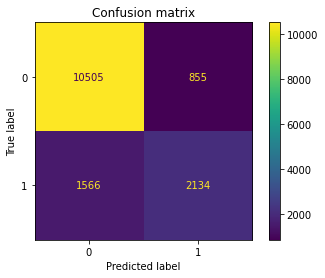

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pred = clf.predict(tf)
print(1 - accuracy_score(ty, pred))

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Generate confusion matrix
matrix = plot_confusion_matrix(clf, tf, ty, normalize=None, values_format='.0f')
plt.title('Confusion matrix')
plt.show()

In [13]:
print(pred[:5])
print(y_le.inverse_transform(pred[:5]))

[0 0 1 1 0]
['<=50K' '<=50K' '>50K' '>50K' '<=50K']


In [16]:
# End